In [1]:
## Uncomment the following lines to set up the environment 
#!pip install torch
#!pip install nilearn
#!pip install nibabel
#!pip install pandas
#!pip install sklearn
#!pip install matplotlib
#!pip install numpy
#!pip install torch torchvision
 
!git clone https://gitlab.inria.fr/epione_ML/mcvae.git

Cloning into 'mcvae'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 347 (delta 152), reused 297 (delta 114), pack-reused 0
Receiving objects: 100% (347/347), 4.72 MiB | 5.96 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
%cd mcvae
!python ./setup.py install

/content/mcvae
running install
running bdist_egg
running egg_info
creating src/mcvae.egg-info
writing src/mcvae.egg-info/PKG-INFO
writing dependency_links to src/mcvae.egg-info/dependency_links.txt
writing top-level names to src/mcvae.egg-info/top_level.txt
writing manifest file 'src/mcvae.egg-info/SOURCES.txt'
writing manifest file 'src/mcvae.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
copying src/__init__.py -> build/lib
creating build/lib/mcvae
copying src/mcvae/__init__.py -> build/lib/mcvae
creating build/lib/mcvae/diagnostics
copying src/mcvae/diagnostics/__init__.py -> build/lib/mcvae/diagnostics
creating build/lib/mcvae/distributions
copying src/mcvae/distributions/normal.py -> build/lib/mcvae/distributions
copying src/mcvae/distributions/kl_utilities.py -> build/lib/mcvae/distributions
copying src/mcvae/distributions/utilities.py -> build/lib/mcvae/distributions
copying src

In [1]:
#Before running this cell, got to Runtime and select "Restart runtime [Ctrl+M]"

import mcvae
print(mcvae.__version__)

2.0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_decomposition import PLSCanonical, CCA

# Random data generation

Our journey in the analysis of heterogeneous data starts with the generation of synthetic data. We first need to generate multivarite correlated random variables X and Y. To do so, we rely on the generative model we have seen during lesson:

$$ z\sim\mathcal{N}(0,1),$$
$$ X = z w_x,$$
$$ Y = z w_y.$$


In [4]:
# #############################################################################

# N subjects
n = 500
# here we define 2 Gaussian latents variables z = (l_1, l_2)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l2]).T

# We define two random transformations from the latent space to the space of X and Y respectively
transform_x = np.random.randint(-8,8, size = 10).reshape([2,5])
transform_y = np.random.randint(-8,8, size = 10).reshape([2,5])

# We compute data X = z w_x, and Y = z w_y
X = latents.dot(transform_x) 
Y = latents.dot(transform_y) 

# We add some random Gaussian noise
X = X + 2*np.random.normal(size = n*5).reshape((n, 5))
Y = Y + 2*np.random.normal(size = n*5).reshape((n, 5))


print('The latent space has dimension ' + str(latents.shape))
print('The transformation for X has dimension ' + str(transform_x.shape))
print('The transformation for Y has dimension ' + str(transform_y.shape))

print('X has dimension ' + str(X.shape))
print('Y has dimension ' + str(Y.shape))


The latent space has dimension (500, 2)
The transformation for X has dimension (2, 5)
The transformation for Y has dimension (2, 5)
X has dimension (500, 5)
Y has dimension (500, 5)


[]

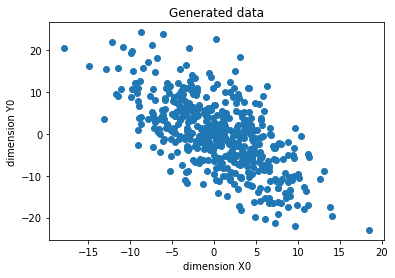

In [5]:
dimension_to_plot = 0

plt.scatter(X[:,1], Y[:,2])
plt.xlabel('dimension X' + str(dimension_to_plot))
plt.ylabel('dimension Y' + str(dimension_to_plot))
plt.title('Generated data')
plt.plot()

## PLS and scikit-learn: basic use


Our newly generated data can be already used to test the PLS and CCA provided by standard machie learning packages, such as scikit-learn.

In [6]:
##########################################################
# We first split the data in trainig and validation sets

# The training set is composed by a random sample of dimension N/2 
train_idx = np.random.choice(range(X.shape[0]), size = int(X.shape[0]/2), replace = False)
X_train = X[train_idx, :]

# The testing set is composed by the remaining subjects
test_idx = np.where(np.in1d(range(X.shape[0]), train_idx, assume_unique =True, invert = True))[0]
X_test = X[test_idx, :]

# We reuse the same indices to split the data Y
Y_train = Y[train_idx, :]
Y_test = Y[test_idx, :]


In [9]:
#######################################
# We fit PLS as provided by scikit-learn

#Defining PLS object
plsca = PLSCanonical(n_components=2)

#Fitting on train data
plsca.fit(X_train, Y_train)

#We project the training data in the latent dimension
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
#We project the testing data in the latent dimension
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

We note that the projections in the latent space retrieved by PLS are indeed correlated. The different dimensions of the projections are however uncorrelated. 

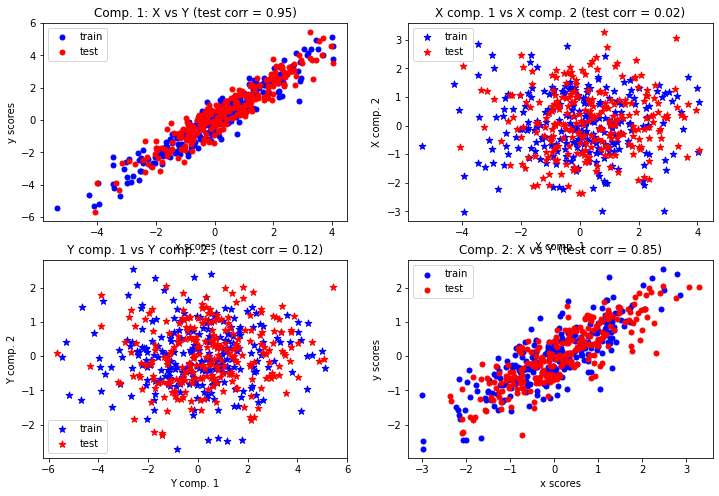

In [8]:
# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])

plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])

plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")



plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")

plt.show()


In [10]:
#We can check the estimated projections
print('X projections: \n' + str(plsca.x_weights_))

print('Y projections: \n' + str(plsca.y_weights_))

X projections: 
[[ 0.58897676  0.077067  ]
 [ 0.43099749  0.71457965]
 [ 0.54799047 -0.1616064 ]
 [-0.13447739  0.39613099]
 [ 0.38596607 -0.54808777]]
Y projections: 
[[ 0.50171592 -0.12829675]
 [-0.32629363 -0.65129874]
 [-0.49959862  0.07737682]
 [-0.45492785  0.62392019]
 [ 0.43041315  0.40507571]]


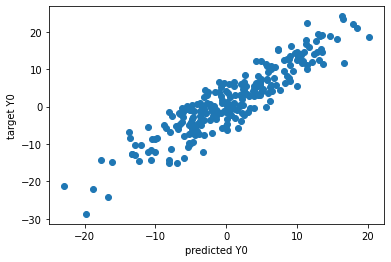

In [11]:
# We can also predict Y from X

predicted_Y_test = plsca.predict(X_test)

plt.scatter(predicted_Y_test[:,dimension_to_plot], Y_test[:,dimension_to_plot])
plt.ylabel('target Y' + str(dimension_to_plot))
plt.xlabel('predicted Y' + str(dimension_to_plot))

plt.show()


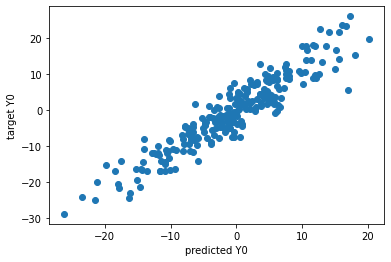

In [13]:
# Prediction for the training data

predicted_Y_train = plsca.predict(X_train)

plt.scatter(predicted_Y_train[:,dimension_to_plot], Y_train[:,dimension_to_plot])
plt.ylabel('target Y' + str(dimension_to_plot))
plt.xlabel('predicted Y' + str(dimension_to_plot))

plt.show()

In [14]:
plsca_4 = PLSCanonical(n_components=4)
plsca_4.fit(X_train, Y_train)

predicted_Y_train = plsca_4.predict(X_train)

print('X projections with 2 components: \n' + str(plsca.x_weights_))

print('Y projections with 2 components: \n' + str(plsca.y_weights_))

print('X projections with 4 components: \n' + str(plsca_4.x_weights_))

print('Y projections with 4 components: \n' + str(plsca_4.y_weights_))


X projections with 2 components: 
[[ 0.58897676  0.077067  ]
 [ 0.43099749  0.71457965]
 [ 0.54799047 -0.1616064 ]
 [-0.13447739  0.39613099]
 [ 0.38596607 -0.54808777]]
Y projections with 2 components: 
[[ 0.50171592 -0.12829675]
 [-0.32629363 -0.65129874]
 [-0.49959862  0.07737682]
 [-0.45492785  0.62392019]
 [ 0.43041315  0.40507571]]
X projections with 4 components: 
[[ 0.58897676  0.077067   -0.47598107 -0.17694944]
 [ 0.43099749  0.71457965  0.30300605 -0.29997129]
 [ 0.54799047 -0.1616064  -0.0973176   0.72866827]
 [-0.13447739  0.39613099  0.45236072  0.53765229]
 [ 0.38596607 -0.54808777  0.6837605  -0.24223686]]
Y projections with 4 components: 
[[ 0.50171592 -0.12829675 -0.04193654  0.49652296]
 [-0.32629363 -0.65129874 -0.68197143  0.01483085]
 [-0.49959862  0.07737682  0.22120892 -0.44460303]
 [-0.45492785  0.62392019 -0.36219338  0.51964836]
 [ 0.43041315  0.40507571 -0.59417073 -0.53435824]]


# Into the guts of latent variable models

After playing with the builti-in implementation of PLS in scikit-learn, we are going to implement our own version based on the NIPALS method.

## NIPALS for PLS

In [15]:
# Nipals method for PLS

n_components = 3


# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x = np.ndarray([X.shape[1],n_components])
loading_y = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
weight_x = np.ndarray([X.shape[1],n_components])
weight_y = np.ndarray([Y.shape[1],n_components])

# Latent variables
scores_x = np.ndarray([X.shape[0],n_components])
scores_y = np.ndarray([Y.shape[0],n_components])


# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(100):
        # estimating Y weights given data Y and latent variables from X
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))

        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)
        # estimating X weights given data X and latent variables from Y
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))

        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

    # Weights are such that X * weights = t
    weight_x[:,i] = w_x
    weight_y[:,i] = w_y
    
    # Latent variables
    scores_x[:,i] = t_x
    scores_x[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

In [19]:
print('The estimated projections for X are: \n' + str(weight_x))

print('\n The estimated projections for Y are: \n' + str(weight_y))

The estimated projections for X are: 
[[ 0.69665023  0.03923534  0.19095112]
 [ 0.35923387  0.756455   -0.02497279]
 [ 0.54632785 -0.2234127  -0.39468166]
 [-0.0375579   0.20475532  0.79685568]
 [ 0.29282209 -0.57827195  0.41492342]]

 The estimated projections for Y are: 
[[ 0.58530023 -0.11947426 -0.76627276]
 [-0.25181703 -0.59222935 -0.27769592]
 [-0.50855779  0.06944454 -0.44763951]
 [-0.38846832  0.63688943 -0.36737557]
 [ 0.42950338  0.47385611  0.01910749]]


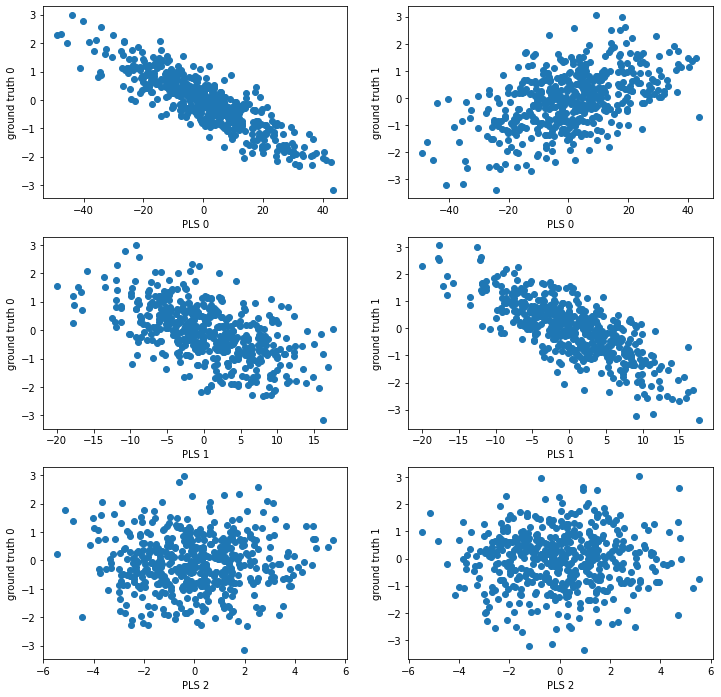

In [18]:
plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.scatter(scores_x[:,0], latents[:,0])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 0')
plt.subplot(3,2,2)
plt.scatter(scores_x[:,0], latents[:,1])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 1')
plt.subplot(3,2,3)
plt.scatter(scores_x[:,1], latents[:,0])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 0')
plt.subplot(3,2,4)
plt.scatter(scores_x[:,1], latents[:,1])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 1')
plt.subplot(3,2,5)
plt.scatter(scores_x[:,2], latents[:,0])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 0')
plt.subplot(3,2,6)
plt.scatter(scores_x[:,2], latents[:,1])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 1')
plt.show()

Once that the PLS parameters are estimated, we can solve the regression problem for predicting Y from X. We adopt the scheme used in scikit-learn, where a rotation matrix is first estimated to accoung for non-cummutativity between projection (weights) and reconstruction (loadings).



In [21]:
# Identifying rotation from X to t
# t_x * loadings_x = X
# t_x * loadings_x.T * weight = X * weight 
# t_x =  X * weight * (loadings_x.T * weight)^-1 = X * rotations_x

rotations_x = weight_x.dot(np.linalg.pinv(loading_x.T.dot(weight_x)))

# Solving the regression from X to Y
# Y = t_x * loadings_y.T
# Y = X * rotations_x * loadings_y.T

regression_coef = np.dot(rotations_x, loading_y.T)

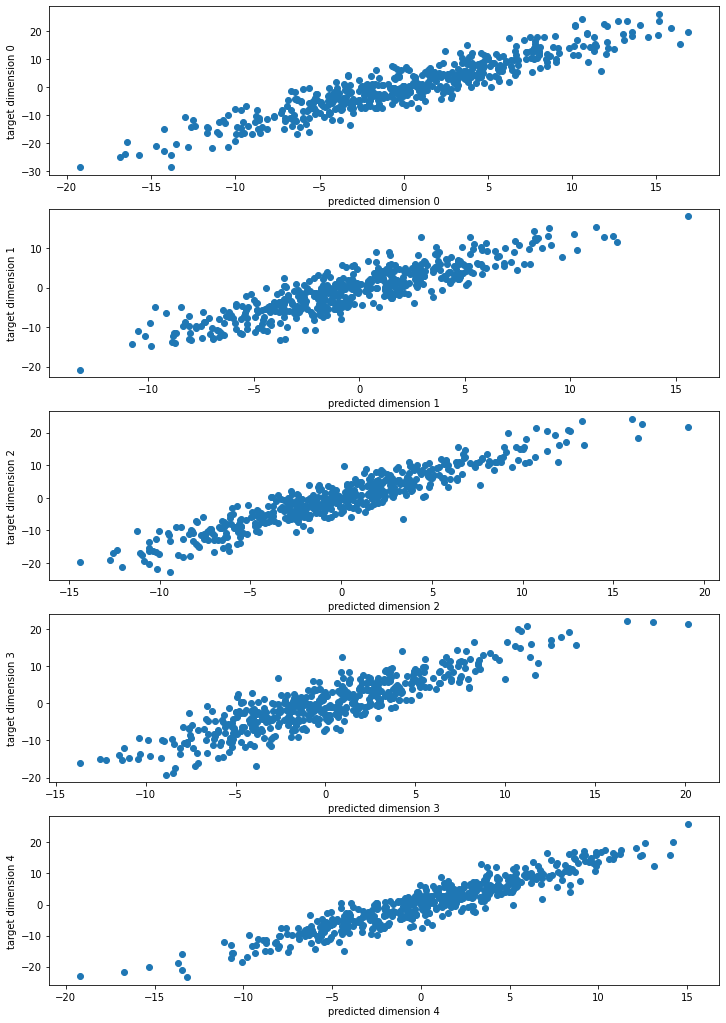

In [22]:
plt.figure(figsize=(12, 18))
for i in range(Y.shape[1]):
  plt.subplot(Y.shape[1], 1, i+1)
  plt.scatter(X.dot(regression_coef)[:,i], Y[:,i])
  plt.xlabel('predicted dimension ' + str(i))
  plt.ylabel('target dimension ' + str(i))
plt.show()

In [23]:
# Comparing with SVD of covariance matrix

eig_val_x, eig_vect, eig_val_y = np.linalg.svd(X.transpose().dot(Y))

In [24]:
print('Eigenvalues for X \n' + str(np.real(eig_val_x[:,:3])))
print('Estimated weights for X\n' + str(np.real(weight_x[:,:3])))

Eigenvalues for X 
[[-0.69665023 -0.03923534  0.19095112]
 [-0.35923387 -0.756455   -0.02497279]
 [-0.54632785  0.2234127  -0.39468166]
 [ 0.0375579  -0.20475532  0.79685568]
 [-0.29282209  0.57827195  0.41492342]]
Estimated weights for X
[[ 0.69665023  0.03923534  0.19095112]
 [ 0.35923387  0.756455   -0.02497279]
 [ 0.54632785 -0.2234127  -0.39468166]
 [-0.0375579   0.20475532  0.79685568]
 [ 0.29282209 -0.57827195  0.41492342]]


In [25]:
print('Eigenvalues for Y \n' + str(np.real(eig_val_y.T[:,:3])))
print('Estimated weights for Y\n' + str(np.real(weight_y[:,:3])))

Eigenvalues for Y 
[[-0.58530023  0.11947426 -0.76627276]
 [ 0.25181703  0.59222935 -0.27769592]
 [ 0.50855779 -0.06944454 -0.44763951]
 [ 0.38846832 -0.63688943 -0.36737557]
 [-0.42950338 -0.47385611  0.01910749]]
Estimated weights for Y
[[ 0.58530023 -0.11947426 -0.76627276]
 [-0.25181703 -0.59222935 -0.27769592]
 [-0.50855779  0.06944454 -0.44763951]
 [-0.38846832  0.63688943 -0.36737557]
 [ 0.42950338  0.47385611  0.01910749]]


In [26]:
# PLS in scikit-learn 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X, Y)

PLSCanonical(algorithm='nipals', copy=True, max_iter=500, n_components=3,
             scale=False, tol=1e-06)

In [27]:
print(plsca.x_weights_)
print(plsca.y_weights_)

[[ 0.69699794  0.04164547  0.18044407]
 [ 0.35777959  0.75612734 -0.00742961]
 [ 0.54644601 -0.22354768 -0.40778695]
 [-0.03734901  0.20596188  0.78003247]
 [ 0.29358041 -0.57805125  0.43891217]]
[[ 0.58531101 -0.11955355 -0.7476096 ]
 [-0.25082735 -0.59075635 -0.33222253]
 [-0.50874773  0.0679888  -0.43018352]
 [-0.38910974  0.63696286 -0.38050062]
 [ 0.42926217  0.47578327 -0.02948722]]


## NIPALS for CCA

In [115]:
import scipy

# Nipals method for CCA

# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x_cca = np.ndarray([X.shape[1],n_components])
loading_y_cca = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
scores_x_cca = np.ndarray([X.shape[0],n_components])
scores_y_cca = np.ndarray([Y.shape[0],n_components])

# Latent variables
weight_x_cca = np.ndarray([X.shape[1],n_components])
weight_y_cca = np.ndarray([Y.shape[1],n_components])

# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(500):
        ## CCA variant
        # estimating Y weights given data Y and latent variables from X
        Y_pinv = scipy.linalg.pinv(current_Y)
        #Y_pinv = np.linalg.solve(current_Y.dot(current_Y.T),current_Y).T
        w_y = Y_pinv.dot(t_x)

        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)

        ## CCA variant
        # estimating X weights given data X and latent variables from Y
        X_pinv = scipy.linalg.pinv(current_X)
        #X_pinv = np.linalg.solve(current_X.dot(current_X.T),current_X).T
        w_x = X_pinv.dot(t_y)

        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

        
    # Weights are such that X * weights = t
    weight_x_cca[:,i] = w_x
    weight_y_cca[:,i] = w_y
    
    # Latent dimensions
    scores_x_cca[:,i] = t_x
    scores_x_cca[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_cca[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_cca[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction

    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_y.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))

 


[[ 0.68272347  0.11121894  0.36452001]
 [ 0.43677416  0.71650108 -0.04609856]
 [ 0.54997523 -0.18462384  0.58028414]
 [ 0.0285024   0.30974761 -0.31472877]
 [ 0.1995792  -0.58670863  0.65514594]]


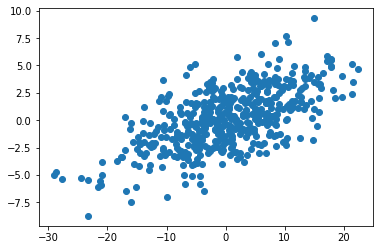

In [123]:
print(weight_x_cca)

plt.scatter(X.dot(weight_x_cca)[:,2], Y.dot(weight_y_cca)[:,2])

[[ 0.68304892  0.00112241  0.13474313]
 [ 0.4337727   0.63882501 -0.0359616 ]
 [ 0.55104412 -0.2863036  -0.36512074]
 [ 0.0275376   0.32117388  0.76425876]
 [ 0.20218176 -0.63779224  0.51297802]]


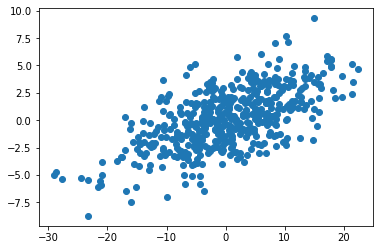

In [122]:
cca = CCA(n_components=3, scale = False)
cca.fit(X,Y)
print(cca.x_weights_)

plt.scatter(X.dot(weight_x_cca)[:,2], Y.dot(weight_y_cca)[:,2])

## Reduced Rank Regression

We finally review reduced rank regression through eigen-decomposition.

In [124]:
# Reduced Rank Regression

n_components = 2
Gamma = np.eye(n_components)

SYX = np.dot(Y.T,X)

SXX = np.dot(X.T,X)

U, S, V = np.linalg.svd(np.dot(SYX, np.dot(np.linalg.pinv(SXX), SYX.T)))

A = V[0:n_components, :].T

B = np.dot(np.dot(A.T,SYX), np.linalg.pinv(SXX))

In [125]:
A

array([[-0.57891273, -0.14813187],
       [ 0.27963189, -0.57928004],
       [ 0.50470437,  0.09279047],
       [ 0.3577794 ,  0.65445268],
       [-0.45158993,  0.45340181]])

In [126]:
B

array([[-1.06209637, -0.8233436 , -0.79743244, -0.10813656, -0.17763258],
       [ 0.08374092,  0.74266869, -0.23562337,  0.34041095, -0.65795928]])

In [127]:
regression_coef_rrr = np.dot(A,B)

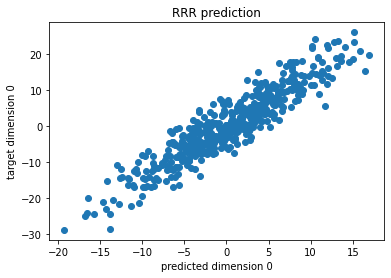

In [128]:
plt.scatter(np.dot(X,regression_coef)[:,0],Y[:,0])
plt.xlabel('predicted dimension 0')
plt.ylabel('target dimension 0')
plt.title('RRR prediction')
plt.show()

## Sparsity in latent variable models

We now focus on the effect of spurious variables in mutivariate models. To explore this new setting, we are going to add spurious random features to our data matrices X and Y.  

In [129]:
## Adding 3 random dimensions
## No association is expected from these features

X_ext = np.hstack([X,np.random.randn(n*3).reshape([n,3])])
Y_ext = np.hstack([Y,np.random.randn(n*3).reshape([n,3])])

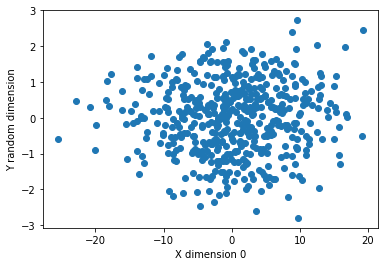

In [130]:
plt.scatter(X_ext[:,0], Y_ext[:,-1])
plt.xlabel('X dimension 0')
plt.ylabel('Y random dimension')
plt.show()

In [131]:
from sklearn import linear_model

n_components = 3

#### Sparse PLS via regularization in NIPALS [Waaijenborg, et al 2007]
# Everything is as for the standard NIPALS algorithm, with the added sparse estimation step   

loading_x_sparse = np.ndarray([X_ext.shape[1],n_components])
loading_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

scores_x_sparse = np.ndarray([X_ext.shape[0],n_components])
scores_y_sparse = np.ndarray([Y_ext.shape[0],n_components])

weight_x_sparse = np.ndarray([X_ext.shape[1],n_components])
weight_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

current_X = X_ext
current_Y = Y_ext

## Penalty parameter for regularization
penalty = 10

eps = 1e-4

for i in range(n_components):
    t_x = current_X[:,0]
    for _ in range(100):
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        t_y = current_Y.dot(w_y)
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        t_x = current_X.dot(w_x)
        
        ## Estimating sparse model for the weights of X
        lasso_x = linear_model.Lasso(alpha = penalty)
        lasso_x.fit(t_x.reshape(-1, 1), current_X)
        
        ## Estimating sparse model for the weights of Y
        lasso_y = linear_model.Lasso(alpha = penalty)
        lasso_y.fit(t_y.reshape(-1, 1), current_Y)
        
        # Replacing the original weights with the sparse estimation
        w_x = (lasso_x.coef_ / (np.sqrt(np.sum(lasso_x.coef_**2) + eps))).reshape([X_ext.shape[1]]) 
        w_y = (lasso_y.coef_ / (np.sqrt(np.sum(lasso_y.coef_**2) + eps))).reshape([Y_ext.shape[1]])

    # Weights are such that X * weights = t
    weight_x_sparse[:,i] = w_x
    weight_y_sparse[:,i] = w_y
    
    # Latent dimensions
    scores_x_sparse[:,i] = t_x
    scores_x_sparse[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_sparse[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_sparse[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

We observe that the new weights are similar to the ones estimated before. However the parameters associated with the spurious dimension are entirely set to zero. This indicates that the model does not find these features necessary to explain the common variability between X and Y. There are also other weights which are set to zero, corresponding to the third latent dimension. This makes sense, as our synthetic data was indeed created with only two latent dimensions.

In [132]:
weight_x_sparse

array([[ 0.72764054,  0.        ,  0.        ],
       [ 0.26947596,  0.88466113, -0.        ],
       [ 0.56256419, -0.        , -0.        ],
       [-0.        ,  0.        ,  0.        ],
       [ 0.28512962, -0.46569785, -0.        ],
       [ 0.        , -0.        , -0.        ],
       [-0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [133]:
weight_y_sparse

array([[ 0.59013049, -0.        , -0.        ],
       [-0.26302781, -0.61145769,  0.        ],
       [-0.50756271,  0.        ,  0.        ],
       [-0.35040047,  0.6819509 , -0.        ],
       [ 0.44949269,  0.40095616,  0.        ],
       [-0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ]])

In [134]:
## Non-sparse parameters previously estimated

weight_x

array([[ 0.69665023,  0.03923534,  0.19095112],
       [ 0.35923387,  0.756455  , -0.02497279],
       [ 0.54632785, -0.2234127 , -0.39468166],
       [-0.0375579 ,  0.20475532,  0.79685568],
       [ 0.29282209, -0.57827195,  0.41492342]])

In [135]:
weight_y

array([[ 0.58530023, -0.11947426, -0.76627276],
       [-0.25181703, -0.59222935, -0.27769592],
       [-0.50855779,  0.06944454, -0.44763951],
       [-0.38846832,  0.63688943, -0.36737557],
       [ 0.42950338,  0.47385611,  0.01910749]])

In [136]:
## PLS result from scikit-learn PLS on the data augmented with spurious dimensions 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X_ext, Y_ext)
print(plsca.x_weights_)
print(plsca.y_weights_)

[[ 0.69697194  0.04167764  0.18524237]
 [ 0.35776523  0.75606419 -0.10952475]
 [ 0.5464214  -0.22348542 -0.23784209]
 [-0.03735712  0.20594569  0.72441739]
 [ 0.29357554 -0.57798507  0.23403724]
 [ 0.00807931 -0.00150422 -0.03094577]
 [-0.0031311   0.01301252  0.49742171]
 [ 0.00075831  0.00567696  0.26302234]]
[[ 5.85300861e-01 -1.19620269e-01 -7.03675112e-01]
 [-2.50817801e-01 -5.90756245e-01 -1.47099373e-01]
 [-5.08730699e-01  6.78568262e-02 -5.85700008e-01]
 [-3.89105389e-01  6.36951669e-01 -2.04120025e-01]
 [ 4.29244298e-01  4.75778936e-01 -2.31647055e-03]
 [-6.84609151e-03  1.88554168e-03  2.32670828e-01]
 [-5.16478961e-04 -1.23805743e-03  1.79963799e-01]
 [ 2.36679216e-03 -3.92296756e-03  1.09387281e-01]]


## Cross-validating components

In addition to sparsity, the optimal number of components in latent variable models can be identified by cross-validation. 
A common strategy is to train the model on a subset of the data and to quantify the *predicted residual error sum of squares* (PRESS) in non-overlapping testing data. We can finally choose the number of latent dimensions leading to the lowest average PRESS. 

In [137]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(X_ext.shape[0]), size = int(X_ext.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(X_ext.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = X_ext[batch1_idx, :]
    X_2 = X_ext[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = Y_ext[batch1_idx, :]
    Y_2 = Y_ext[batch2_idx, :]

    # Creating a model for each data batch
    plsca1 = PLSCanonical(n_components = k+1, scale = False)
    plsca2 = PLSCanonical(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    plsca1.fit(X_1,Y_1)
    plsca2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((plsca1.predict(X_2) - Y_2)**2)
    err2 = np.sum((plsca2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


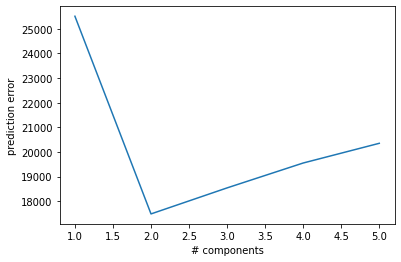

In [138]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

# Multi-channel Variational Autoencoder

The last part of this tutorial concerns the use of the *multi-channel variational autoencoder* (https://gitlab.inria.fr/epione_ML/mcvae), a more advanced  methods for the joint analysis and prediction of several modalities.




In [160]:
import torch
from mcvae.models import Mcvae
from mcvae.models.utils import DEVICE, load_or_fit
from mcvae.diagnostics import *
from mcvae.plot import lsplom

print(f"Running on {DEVICE}")

FORCE_REFIT = False

Running on cpu


In [162]:
### Data in mcvae is specified by: 
# 1 - a dictionary with the data characteristics

init_dict = {
    'n_channels': 2, # X and Y
    'lat_dim': n_components,  
    'n_feats': tuple([X.shape[1], Y.shape[1]]),
}

# 2 - a list with the different data channels

data = []
data.append(torch.FloatTensor(X)) #warning: data matrices must be converted to type torch.FLoatTensor
data.append(torch.FloatTensor(Y)) #warning: data matrices must be converted to type torch.FLoatTensor

In [163]:
# Here we create an instance of the model

adam_lr = 1e-2
n_epochs = 4000

# Multi-Channel VAE
torch.manual_seed(24)
model = Mcvae(**init_dict)
model.to(DEVICE)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_logvar): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
    (1): VAE(
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_logvar): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
  )
)

In [164]:
###################
## Model Fitting ##
###################
model.optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)
load_or_fit(model=model, data=data, epochs=n_epochs, ptfile='model.pt', force_fit=FORCE_REFIT)

	Creating model.pt.running
	Created: 2020-12-29 13:02:59.755737
Start fitting: 2020-12-29 13:02:59.756956
	Model destination: model.pt
====> Epoch:    0/4000 (0%)	Loss: 110656.7812	LL: -102460.9531	KL: 8195.8281	LL/KL: -12.5016
====> Epoch:   10/4000 (0%)	Loss: 10823.4326	LL: -10415.5234	KL: 407.9087	LL/KL: -25.5340
====> Epoch:   20/4000 (0%)	Loss: 5543.0308	LL: -5248.7119	KL: 294.3190	LL/KL: -17.8334
====> Epoch:   30/4000 (1%)	Loss: 3149.8499	LL: -2841.0576	KL: 308.7921	LL/KL: -9.2006
====> Epoch:   40/4000 (1%)	Loss: 2364.1697	LL: -2084.0603	KL: 280.1094	LL/KL: -7.4402
====> Epoch:   50/4000 (1%)	Loss: 1946.6538	LL: -1690.6829	KL: 255.9709	LL/KL: -6.6050
====> Epoch:   60/4000 (2%)	Loss: 1724.4836	LL: -1479.0823	KL: 245.4014	LL/KL: -6.0272
====> Epoch:   70/4000 (2%)	Loss: 1535.3989	LL: -1298.0029	KL: 237.3960	LL/KL: -5.4677
====> Epoch:   80/4000 (2%)	Loss: 1361.6633	LL: -1123.2479	KL: 238.4153	LL/KL: -4.7113
====> Epoch:   90/4000 (2%)	Loss: 1251.4336	LL: -1012.9335	KL: 238.5001	

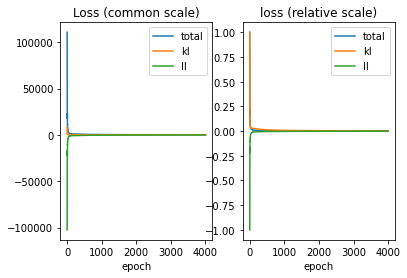

In [165]:
## Plotting model convergence
plot_loss(model)

The plot above indicates that the model converged smoothly.

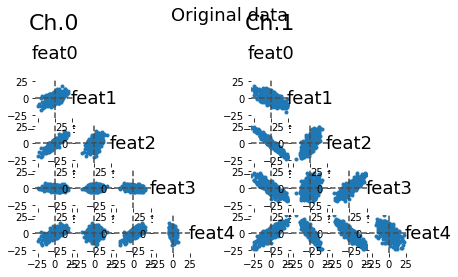

In [166]:
# We can plot the original data, dimension x dimension
lsplom(data, title = 'Original data')

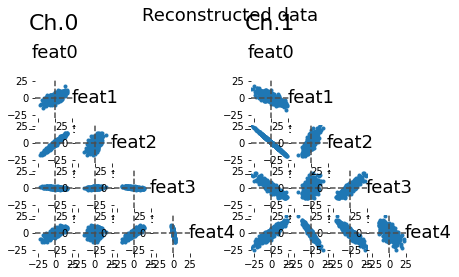

In [169]:
# We can estimate the reconstructed data (decoding from the latent space)
x_hat = model.reconstruct(data)

# Plotting the reconstructed data across dimensions
lsplom(x_hat, title = 'Reconstructed data')

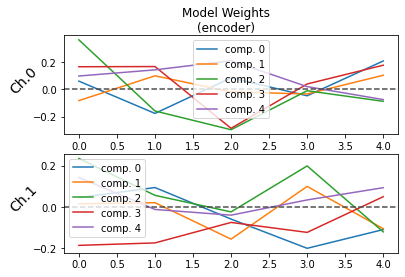

In [170]:
## Plotting the weights of the encoder
plot_weights(model, side = 'encoder')

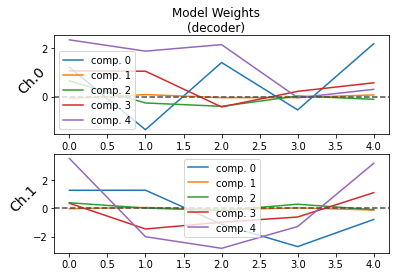

In [171]:
## Plotting the weights of the decoder
plot_weights(model, side = 'decoder')

In [172]:
# Inspecting model parameters

# Decoding parameters
weights_decoding_X = model.vae[0].W_out
weights_decoding_Y = model.vae[1].W_out

In [173]:
weights_decoding_X.weight

Parameter containing:
tensor([[ 1.2104, -0.0701,  0.6539,  1.0653,  2.3346],
        [-1.3466,  0.0929, -0.2512,  1.0495,  1.8724],
        [ 1.4067, -0.0346, -0.3883, -0.4143,  2.1396],
        [-0.5362, -0.0296,  0.0350,  0.2258, -0.0364],
        [ 2.1773,  0.0789, -0.1018,  0.5748,  0.3067]], requires_grad=True)

In [174]:
weights_decoding_Y.weight

Parameter containing:
tensor([[ 1.2864, -0.0253,  0.3995,  0.3654,  3.5504],
        [ 1.2925,  0.0657,  0.0224, -1.4665, -2.0154],
        [-1.1275, -0.0988, -0.1529, -0.9834, -2.8397],
        [-2.7176,  0.0333,  0.2969, -0.6132, -1.2898],
        [-0.7875, -0.1132, -0.0962,  1.1184,  3.2061]], requires_grad=True)

In [175]:
# Encoding parameters
weights_encoding_X = model.vae[0].W_mu
weights_encoding_Y = model.vae[1].W_mu

In [176]:
weights_encoding_X.weight

Parameter containing:
tensor([[ 0.0599, -0.1773,  0.0840, -0.0477,  0.2080],
        [-0.0832,  0.0991, -0.0191, -0.0343,  0.1030],
        [ 0.3633, -0.1594, -0.2969, -0.0105, -0.0883],
        [ 0.1657,  0.1670, -0.2867,  0.0391,  0.1770],
        [ 0.0975,  0.1428,  0.2103,  0.0194, -0.0756]], requires_grad=True)

In [177]:
weights_encoding_Y.weight

Parameter containing:
tensor([[ 0.0456,  0.0943, -0.0584, -0.1999, -0.1092],
        [ 0.0155,  0.0209, -0.1555,  0.0997, -0.1049],
        [ 0.2351,  0.0565, -0.0236,  0.1989, -0.1204],
        [-0.1857, -0.1738, -0.0746, -0.1228,  0.0500],
        [ 0.1432, -0.0118, -0.0395,  0.0343,  0.0935]], requires_grad=True)

In [180]:
# Here we compute the encoding and plot the latent dimensions against our original ground truth for the syntetic data

encoding = model.encode(data)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

We note that the estimated encoding is correlated with the original latent dimensions. There seems to be however some redundancy. This motivates the use of a *sparse model*.

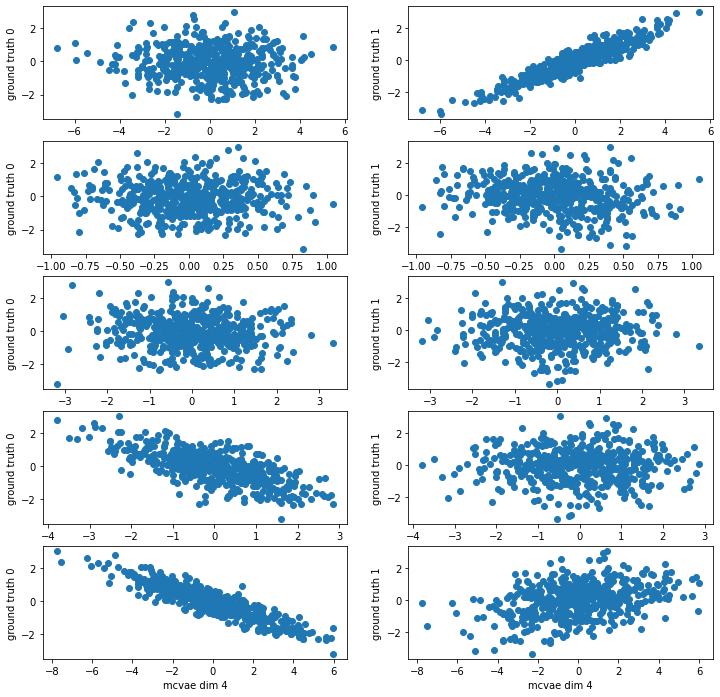

In [181]:
plt.figure(figsize=(12, 12))
for idx,k in enumerate(range(n_components)):
  plt.subplot(n_components,2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(n_components,2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')
plt.show()

In [182]:
# Calling sparse mcvae

adam_lr = 1e-2
n_epochs = 4000

model_sparse1 = Mcvae(sparse=True, **init_dict)
model_sparse1.to(DEVICE)
print(model_sparse1)

model_sparse1.optimizer = torch.optim.Adam(model_sparse1.parameters(), lr=adam_lr)
load_or_fit(model=model_sparse1, data=data, epochs=n_epochs, ptfile='model_sparse1.pt', force_fit=FORCE_REFIT)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
    (1): VAE(
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
  )
)
	Creating model_sparse1.pt.running
	Created: 2020-12-29 13:06:59.948894
Start fitting: 2020-12-29 13:06:59.949373
	Model destination: model_sparse1.pt
====> Epoch:    0/4000 (0%)	Loss: 11051.4580	LL: -11047.1475	KL: 4.3107	LL/KL: -2562.7432
====> Epoch:   10/4000 (0%)	Loss: 7701.0723	LL: -7696.4062	KL: 4.6659	LL/KL: -1649.5033
====> Epoch:   20/4000 (0%)	Loss: 4758.5415	LL: -4753.4805	KL: 5.0613	LL/KL: -939.1905
====> Epoch:   30/4000 (1%)	Loss: 2810.4670	LL: -2804.9038	KL: 5.5632	LL/KL: -504.1913
====> Epoch:   40/4000 (1%)	Loss: 2059.2537	LL: -2053.1147	KL: 6.1390	LL/KL: -334.4406
====> Epoch:   50/4000 (1%)	Loss: 1840.2078	LL: -1833.5222	KL: 6.6856	LL/KL: -274.

The sparse model estimates a probability of redundancy associated to each dimension. This means that we can retain only the dimensions with low probability of redundancy. In this case the model correctly identifies only 2 meaningful latent dimensions. 

Probability of redundancy:  [[0.32942933 0.00557985 0.02115972 0.14265281 0.42765433]]


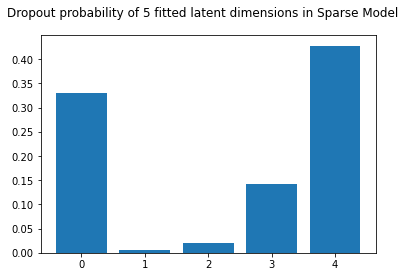

In [183]:
print('Probability of redundancy: ', model_sparse1.dropout.detach().numpy())
plot_dropout(model_sparse1, sort=False)

In [184]:
# We fix a redundancy threshold
dropout_threshold = 0.10

kept components: [1, 2]


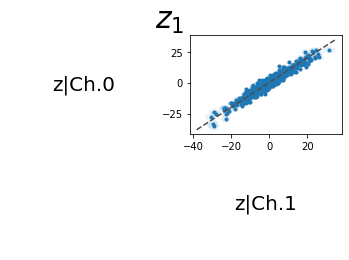

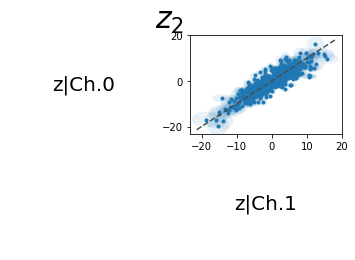

In [185]:
# We plot the remaining latent dimensions
keep = (model_sparse1.dropout.squeeze() < dropout_threshold).tolist()
kept_comps = [i for i, kept in enumerate(keep) if kept]
print(f'kept components: {kept_comps}')

plot_latent_space(model_sparse1, data=data, comp=kept_comps);

In [186]:
# We repeate the same exercise with the synthetic data with redundant dimensions

init_dict = {
    'n_channels': 2, # X and Y
    'lat_dim': n_components + 3,
    'n_feats': tuple([X_ext.shape[1], Y_ext.shape[1]]),
}


data_sparse = []
data_sparse.append(torch.FloatTensor(X_ext))
data_sparse.append(torch.FloatTensor(Y_ext))

model_sparse = Mcvae(sparse=True, **init_dict)
model_sparse.to(DEVICE)
print(model_sparse)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
    (1): VAE(
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
  )
)


In [187]:
# Fit (or load model if existing)
model_sparse.optimizer = torch.optim.Adam(model_sparse.parameters(), lr=adam_lr)
load_or_fit(model=model_sparse, data=data_sparse, epochs=n_epochs, ptfile='model_sparse.pt', force_fit=FORCE_REFIT)

	Creating model_sparse.pt.running
	Created: 2020-12-29 13:08:53.681949
Start fitting: 2020-12-29 13:08:53.683372
	Model destination: model_sparse.pt
====> Epoch:    0/4000 (0%)	Loss: 12081.6670	LL: -12074.7354	KL: 6.9314	LL/KL: -1742.0291
====> Epoch:   10/4000 (0%)	Loss: 7292.2603	LL: -7284.7720	KL: 7.4884	LL/KL: -972.8041
====> Epoch:   20/4000 (0%)	Loss: 4533.3975	LL: -4525.3740	KL: 8.0234	LL/KL: -564.0226
====> Epoch:   30/4000 (1%)	Loss: 2815.0894	LL: -2806.4514	KL: 8.6378	LL/KL: -324.9018
====> Epoch:   40/4000 (1%)	Loss: 1929.3705	LL: -1920.0391	KL: 9.3314	LL/KL: -205.7600
====> Epoch:   50/4000 (1%)	Loss: 1646.1641	LL: -1636.0817	KL: 10.0824	LL/KL: -162.2715
====> Epoch:   60/4000 (2%)	Loss: 1433.7029	LL: -1422.8259	KL: 10.8769	LL/KL: -130.8116
====> Epoch:   70/4000 (2%)	Loss: 1193.8840	LL: -1182.2217	KL: 11.6623	LL/KL: -101.3708
====> Epoch:   80/4000 (2%)	Loss: 1136.0216	LL: -1123.6265	KL: 12.3952	LL/KL: -90.6503
====> Epoch:   90/4000 (2%)	Loss: 1078.4856	LL: -1065.3933	KL:

We see that the model recognises again only two meaningful latent dimensions

Probability of redundancy:  [[0.04130702 0.5616842  0.34008628 0.54585755 0.00458319 0.52429235
  0.6214277  0.46797082]]
Non-redundant components: [0, 4]


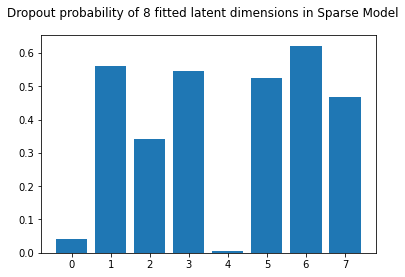

In [188]:
print('Probability of redundancy: ', model_sparse.dropout.detach().numpy())
indices = np.where(model_sparse.dropout.detach().numpy().flatten() < 0.2)[0]
non_redundant_comps = indices.tolist()
print(f'Non-redundant components: {non_redundant_comps}')
plot_dropout(model_sparse, sort=False)

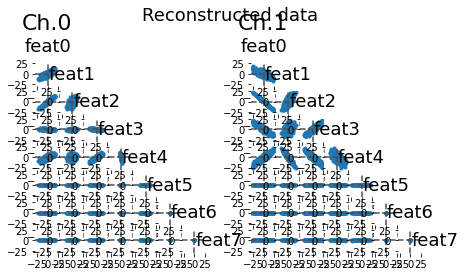

In [189]:
x_hat = model_sparse.reconstruct(data_sparse, dropout_threshold=0.2)
lsplom(x_hat, title = 'Reconstructed data')

<Figure size 864x576 with 0 Axes>

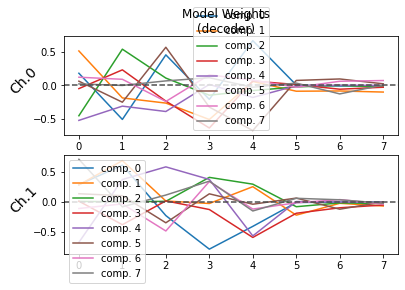

In [190]:
## Plotting the weights of the decoder
plt.figure(figsize=(12, 8))
plot_weights(model_sparse, side = 'decoder')

<Figure size 864x576 with 0 Axes>

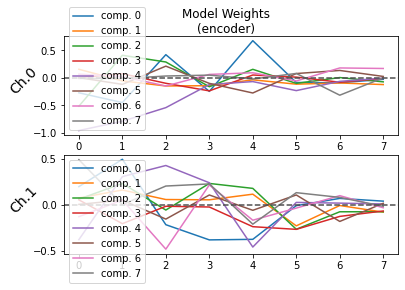

In [191]:
plt.figure(figsize=(12, 8))
plot_weights(model_sparse, side = 'encoder')

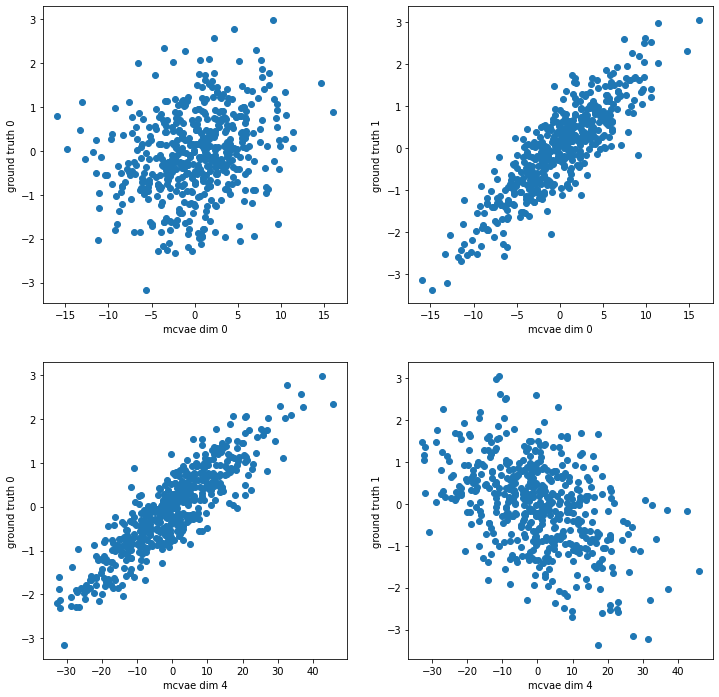

In [192]:
# PLotting estimated encoding vs ground truth

encoding = model_sparse.encode(data_sparse)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
  plt.subplot(len(indices),2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(len(indices),2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')

plt.show()

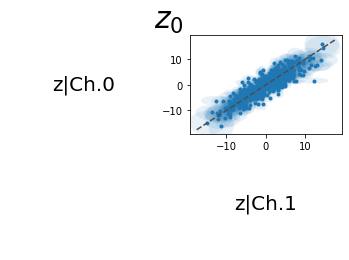

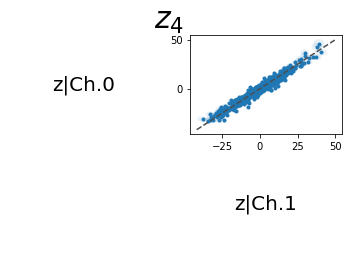

In [193]:
plot_latent_space(model_sparse, data_sparse, comp=non_redundant_comps);

### Increasing the number of channels

In this section we explore the use of the model on data with multiple modalities (or channels)

In [202]:
# generating a new modality z
# This modality has meaningful as well as redundant dimensions

size_z = 10
size_z_redundant = 4

transform_z = np.random.randint(-8,8, size = 2*size_z).reshape([2,size_z])

Z = latents.dot(transform_z) + 2*np.random.normal(size = n*size_z).reshape((n, size_z))
Z = np.hstack([Z,np.random.randn(n*size_z_redundant).reshape([n,size_z_redundant])])

In [207]:
print(X_ext.shape,Y_ext.shape, Z.shape)

(500, 8) (500, 8) (500, 14)


In [208]:
init_dict = {
    'n_channels': 3, # X and Y and Z
    'lat_dim': n_components + 3,
    'n_feats': tuple([X_ext.shape[1], Y_ext.shape[1], Z.shape[1]]),
}

data_multi = []
data_multi.append(torch.FloatTensor(X_ext))
data_multi.append(torch.FloatTensor(Y_ext))
data_multi.append(torch.FloatTensor(Z))

adam_lr = 1e-2
n_epochs = 4000

model_multi = Mcvae(sparse=True, **init_dict)
model_multi.to(DEVICE)
print(model_multi)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
    (1): VAE(
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
    (2): VAE(
      (W_mu): Linear(in_features=14, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=14, bias=True)
    )
  )
)


In [212]:
# Fit (or load)
model_multi.optimizer = torch.optim.Adam(model_multi.parameters(), lr=adam_lr)
load_or_fit(model=model_multi, data=data_multi, epochs=n_epochs, ptfile='model_multi.pt', force_fit=True)

	Creating model_multi.pt.running
	Created: 2020-12-29 13:20:53.421075
Start fitting: 2020-12-29 13:20:53.421333
	Model destination: model_multi.pt
====> Epoch:    0/4000 (0%)	Loss: 19681.0312	LL: -19649.0703	KL: 31.9619	LL/KL: -614.7663
====> Epoch:   10/4000 (0%)	Loss: 10758.3174	LL: -10725.2334	KL: 33.0841	LL/KL: -324.1806
====> Epoch:   20/4000 (0%)	Loss: 4811.2188	LL: -4776.9438	KL: 34.2748	LL/KL: -139.3719
====> Epoch:   30/4000 (1%)	Loss: 2829.7051	LL: -2794.0664	KL: 35.6387	LL/KL: -78.3997
====> Epoch:   40/4000 (1%)	Loss: 2200.8638	LL: -2163.8584	KL: 37.0053	LL/KL: -58.4743
====> Epoch:   50/4000 (1%)	Loss: 1925.4681	LL: -1887.2709	KL: 38.1973	LL/KL: -49.4085
====> Epoch:   60/4000 (2%)	Loss: 1817.1272	LL: -1777.9266	KL: 39.2005	LL/KL: -45.3547
====> Epoch:   70/4000 (2%)	Loss: 1716.6744	LL: -1676.6254	KL: 40.0491	LL/KL: -41.8642
====> Epoch:   80/4000 (2%)	Loss: 1633.9839	LL: -1593.2035	KL: 40.7804	LL/KL: -39.0679
====> Epoch:   90/4000 (2%)	Loss: 1568.2759	LL: -1526.8586	KL: 

Probability of redundancy:  [[0.82945085 0.7076558  0.633131   0.00584694 0.80852157 0.01566803
  0.8571503  0.5157301 ]]
Non-redundant components:  [3 5]


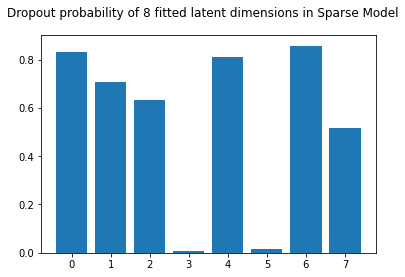

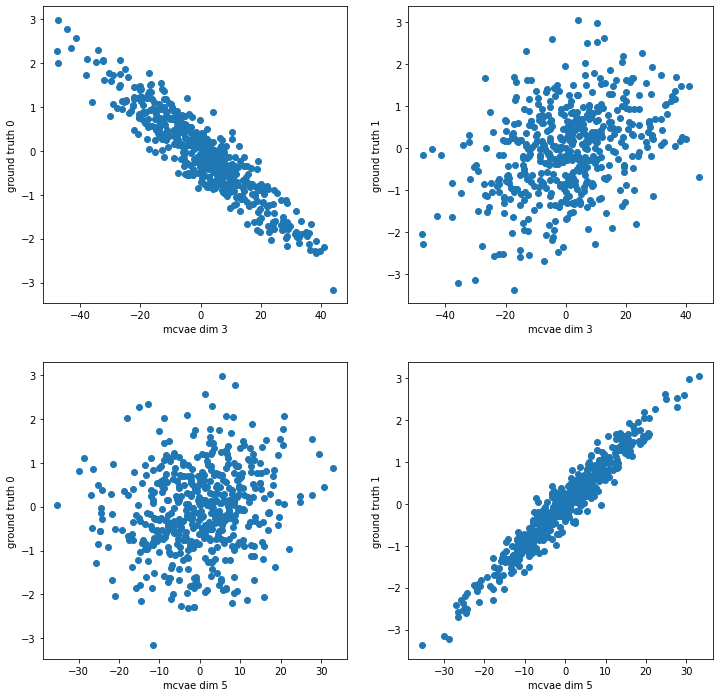

In [213]:
print('Probability of redundancy: ', model_multi.dropout.detach().numpy())
indices = np.where(model_multi.dropout.detach().numpy().flatten() < 0.2)[0]
print('Non-redundant components: ', indices)
plot_dropout(model_multi, sort=False)

encoding = model_multi.encode(data_multi)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()
encoding_z = encoding[2].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
    plt.subplot(len(indices),2,2*idx+1)
    plt.scatter(encoding_z[:,k], latents[:,0])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 0')
    plt.subplot(len(indices),2,2*idx+2)
    plt.scatter(encoding_z[:,k], latents[:,1])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 1')

plt.show()

The multi-channel variational autoencoder allows to predict each channel from any other.

In [214]:
# We compute the reconstruction of the data from the encoding
z = [_.sample() for _ in encoding]
reconstruction = model_multi.decode(z)

# This variable has several dimensions over two indices:
# the first index indicates the modality from which the encoding is done (0:x, 1:y, 3:z, ...) 
# the second index indicates the modality to decode(0:x, 1:y, 3:z, ...)

decoding_x_from_x = reconstruction[0][0].loc.detach().numpy()
decoding_x_from_y = reconstruction[1][0].loc.detach().numpy()
decoding_x_from_z = reconstruction[2][0].loc.detach().numpy()

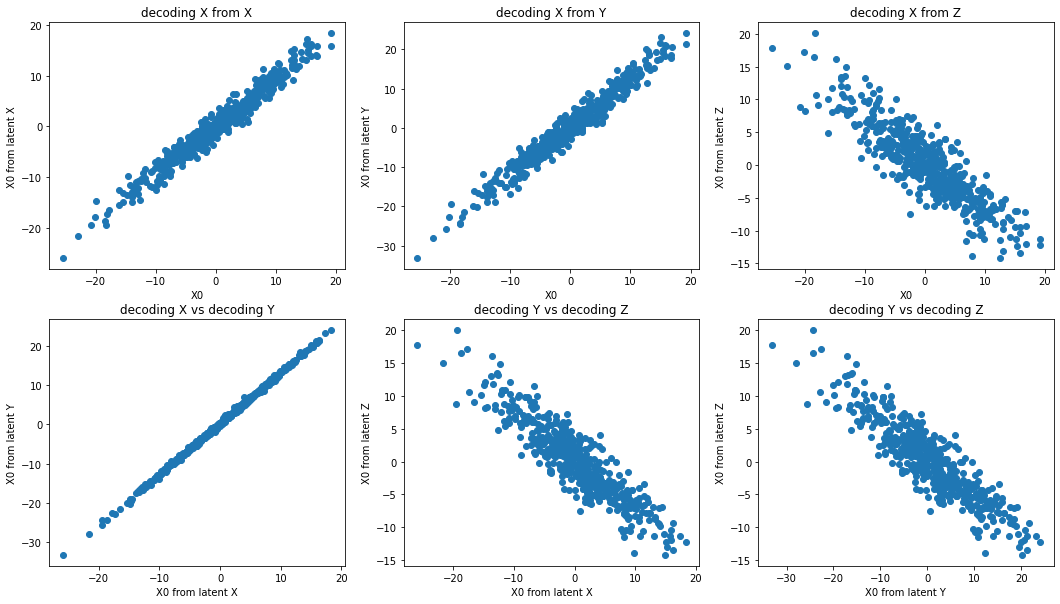

In [215]:
plt.figure(figsize=(18, 10))
plt.subplot(2,3,1)
plt.scatter(X_ext[:,0], decoding_x_from_x[:,0])
plt.title('decoding X from X')
plt.xlabel('X0')
plt.ylabel('X0 from latent X')
plt.subplot(2,3,2)
plt.scatter(X_ext[:,0], decoding_x_from_y[:,0])
plt.title('decoding X from Y')
plt.ylabel('X0 from latent Y')
plt.xlabel('X0')
plt.subplot(2,3,3)
plt.scatter(X_ext[:,0], decoding_x_from_z[:,0])
plt.title('decoding X from Z')
plt.xlabel('X0')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,4)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_y[:,0])
plt.title('decoding X vs decoding Y')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Y')
plt.subplot(2,3,5)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,6)
plt.scatter(decoding_x_from_y[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent Y')
plt.ylabel('X0 from latent Z')
plt.show()

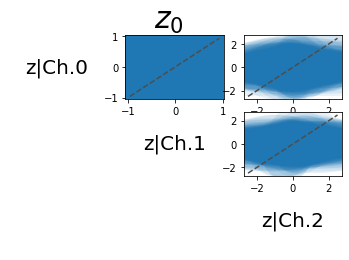

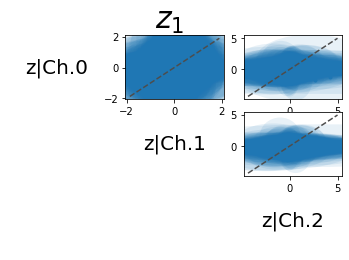

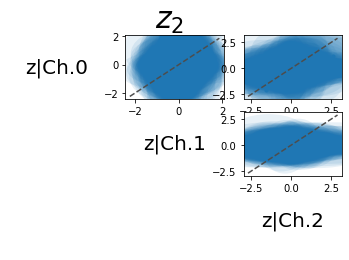

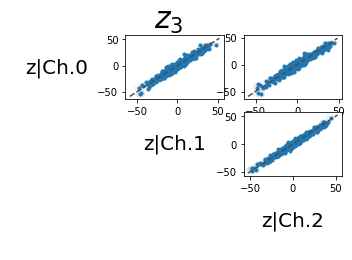

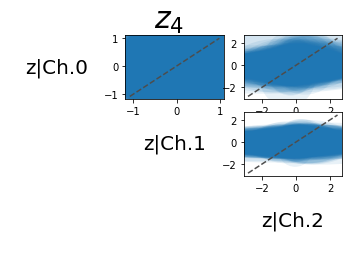

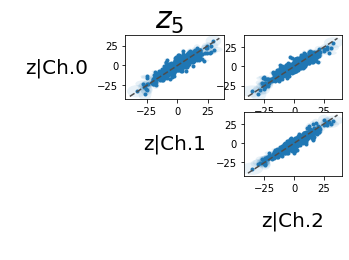

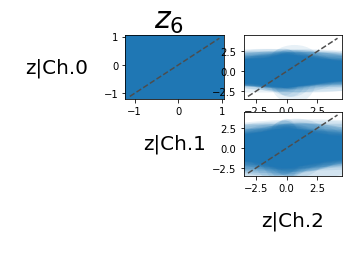

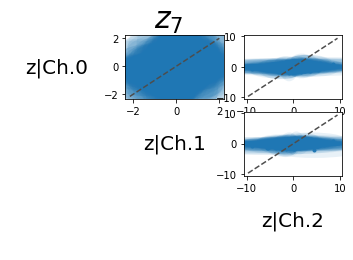

In [216]:
plot_latent_space(model_multi, data_multi);

# Application to (pseudo-) neurological data

We are going to load volumetric and cognitive data for a synthetic sample generated from the ADNI dataset.
The exercise consists in applying the methods seen so far to understand the relationship between this kind of variables.

In [217]:
import pandas as pd

adni = pd.read_csv('https://marcolorenzi.github.io/material/pseudo_adni.csv')

brain_volume_cols = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
cognition_cols = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']

adni[brain_volume_cols]


,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl
0,0.684331,0.012699,0.003786,0.012678,0.002214
1,0.735892,0.012803,0.004866,0.015071,0.003041
2,0.738731,0.030492,0.004300,0.012419,0.002316
3,0.696179,0.032797,0.004720,0.012312,0.002593
4,0.841806,0.004030,0.006820,0.016948,0.002896
...,...,...,...,...,...
995,0.767153,0.011417,0.005209,0.012879,0.002208
996,0.695168,0.011908,0.004641,0.012534,0.002197
997,0.628691,0.041537,0.003478,0.010870,0.001939
998,0.714763,0.020461,0.004713,0.013989,0.001981


In [218]:
volumes_value = adni[brain_volume_cols].values

# Standardization of volumetric measures
for i in range(volumes_value.shape[1]):
    volumes_value[:,i] = (volumes_value[:,i] - np.mean(volumes_value[:,i]))/np.std(volumes_value[:,i])

In [219]:
adni[cognition_cols]

,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl
0,1,8,27.0,23.739439,4.0,5.821573,3
1,0,0,30.0,64.933800,9.0,4.001653,0
2,0,8,24.0,36.987722,3.0,6.876316,0
3,0,3,29.0,50.314425,5.0,4.733481,3
4,0,0,30.0,57.217830,9.0,7.225401,0
...,...,...,...,...,...,...,...
995,1,2,29.0,61.896022,8.0,1.663102,0
996,0,1,29.0,62.083170,8.0,5.241477,1
997,3,14,24.0,22.289059,2.0,5.437600,7
998,0,13,26.0,31.650504,2.0,1.669603,4


In [220]:
cognition_value = adni[cognition_cols].values

# Standardization of cognitive measures

for i in range(cognition_value.shape[1]):
    cognition_value[:,i] = (cognition_value[:,i] - np.mean(cognition_value[:,i]))/np.std(cognition_value[:,i])

In [221]:
plsca_adni = PLSCanonical(n_components=3, scale = False)
plsca_adni.fit(cognition_value,volumes_value)
print(plsca_adni.x_weights_)
print(plsca_adni.y_weights_)

[[ 0.38442715 -0.0914859   0.3212761 ]
 [ 0.46751116 -0.13784339  0.29848234]
 [-0.42755384  0.04820369  0.06450696]
 [-0.41248938 -0.01061314  0.43066352]
 [-0.3504303  -0.18746317  0.64581907]
 [ 0.08267813  0.96398703  0.23059686]
 [ 0.38866726 -0.07602536  0.38444838]]
[[-0.38267896  0.49605567  0.326012  ]
 [ 0.30522362 -0.19887222  0.19846392]
 [-0.51586765 -0.39589381  0.68942719]
 [-0.48952454  0.48804833 -0.30834445]
 [-0.5046203  -0.56520397 -0.53286217]]


In [222]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(cognition_value.shape[0]), size = int(cognition_value.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(cognition_value.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = cognition_value[batch1_idx, :]
    X_2 = cognition_value[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = volumes_value[batch1_idx, :]
    Y_2 = volumes_value[batch2_idx, :]

    # Creating a model for each data batch
    cca_adni1 = CCA(n_components = k+1, scale = False)
    cca_adni2 = CCA(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    cca_adni1.fit(X_1,Y_1)
    cca_adni2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((cca_adni1.predict(X_2) - Y_2)**2)
    err2 = np.sum((cca_adni2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


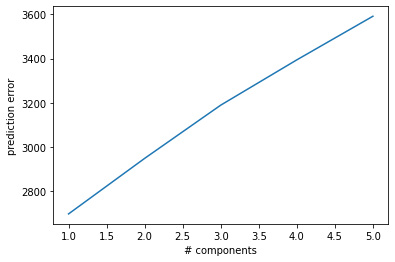

In [223]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

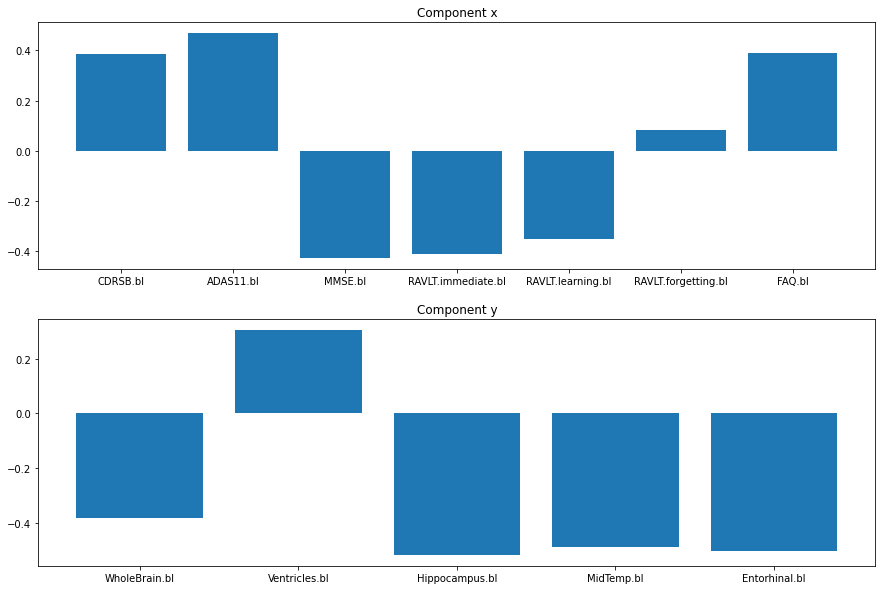

In [224]:
plsca_adni = PLSCanonical(n_components=1, scale = False)
plsca_adni.fit(cognition_value,volumes_value)

f = plt.figure(figsize=(15,10))
f.add_subplot(2,1,1)
plt.bar(np.arange(len(plsca_adni.x_weights_[:,0])), plsca_adni.x_weights_[:,0], tick_label = cognition_cols)
plt.title('Component x')
f.add_subplot(2,1,2)
plt.bar(np.arange(len(plsca_adni.y_weights_[:,0])), plsca_adni.y_weights_[:,0], tick_label = brain_volume_cols)
plt.title('Component y')
plt.show()


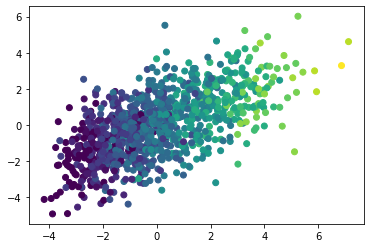

In [225]:
plt.scatter(plsca_adni.x_scores_[:,0], plsca_adni.y_scores_[:,0], c = cognition_value[:,1])
plt.show()

## McVAE

In this last application we apply the multichannel autoencoder to the pseudo-ADNI data, for jointly modeling different modalities across individuals. We focus on the joint analysis of:

- brain volumes;
- sociodemographic information (e.g. age, sex, scholarity); 
- cognition; 
- apoe genotype;
- fluid biomarkers (abeta and tay concentrations in the CSF).

We first import and standardize the different data modalities.

In [229]:
adni = pd.read_csv('https://marcolorenzi.github.io/material/pseudo_adni.csv')

volume_cols = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
volumes_value = adni[volume_cols].values

for i in range(volumes_value.shape[1]):
    volumes_value[:,i] = (volumes_value[:,i] - np.mean(volumes_value[:,i]))/np.std(volumes_value[:,i])

In [230]:
demog_cols = ['SEX', 'AGE', 'PTEDUCAT']
demog_value = adni[demog_cols].values

for i in range(demog_value.shape[1]):
    demog_value[:,i] = (demog_value[:,i] - np.mean(demog_value[:,i]))/np.std(demog_value[:,i])


In [231]:
cognition_cols = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']
cognition_value = adni[cognition_cols].values

for i in range(cognition_value.shape[1]):
    cognition_value[:,i] = (cognition_value[:,i] - np.mean(cognition_value[:,i]))/np.std(cognition_value[:,i])

In [232]:
apoe_cols = ['APOE4']
apoe_value = adni[apoe_cols].values

for i in range(apoe_value.shape[1]):
    apoe_value[:,i] = (apoe_value[:,i] - np.mean(apoe_value[:,i]))/np.std(apoe_value[:,i])

In [233]:
fluid_cols = ['ABETA.MEDIAN.bl', 'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl']
fluid_value = adni[fluid_cols].values

for i in range(fluid_value.shape[1]):
    fluid_value[:,i] = (fluid_value[:,i] - np.mean(fluid_value[:,i]))/np.std(fluid_value[:,i])

We have 5 channels in total as an input for the model

In [234]:
# Defining data characteristics

init_dict = {
    'n_channels': 5, 
    'lat_dim': 5, # We fit 5 latent dimensions
    'n_feats': tuple([volumes_value.shape[1], demog_value.shape[1], cognition_value.shape[1], apoe_value.shape[1], fluid_value.shape[1]]),
}

In [236]:
# Creating a list with multimodal data

data_adni = []
data_adni.append(torch.FloatTensor(volumes_value))
data_adni.append(torch.FloatTensor(np.array(demog_value)))
data_adni.append(torch.FloatTensor(cognition_value))
data_adni.append(torch.FloatTensor(apoe_value))
data_adni.append(torch.FloatTensor(fluid_value))

In [237]:
# Running the model

adam_lr = 1e-2
n_epochs = 6000

model_adni = Mcvae(sparse=True, **init_dict)
model_adni.to(DEVICE)
print(model_adni)

model_adni.optimizer = torch.optim.Adam(model_adni.parameters(), lr=adam_lr)
load_or_fit(model=model_adni, data=data_adni, epochs=n_epochs, ptfile='model_adni.pt', force_fit=FORCE_REFIT)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
    (1): VAE(
      (W_mu): Linear(in_features=3, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=3, bias=True)
    )
    (2): VAE(
      (W_mu): Linear(in_features=7, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=7, bias=True)
    )
    (3): VAE(
      (W_mu): Linear(in_features=1, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=1, bias=True)
    )
    (4): VAE(
      (W_mu): Linear(in_features=3, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=3, bias=True)
    )
  )
)
	Creating model_adni.pt.running
	Created: 2020-12-29 13:25:43.427523
Start fitting: 2020-12-29 13:25:43.428089
	Model destination: model_adni.pt
====> Epoch:    0/6000 (0%)	Loss: 1200.4030	LL: -1189.6807	KL: 10.7223	LL/KL: -110.953

The model identified only a significant dimension, that we are going to store and analyze:

Rendundancy:  [[0.46585083 0.9875569  0.9944062  0.9871113  0.9947454 ]]
Significant dimensions:  [0]


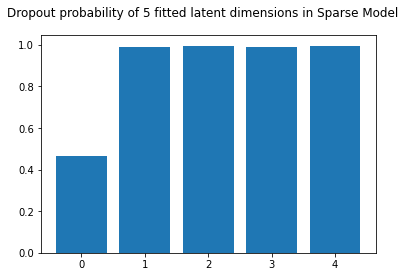

In [238]:
print('Rendundancy: ', model_adni.dropout.detach().numpy())
significant_dim = np.where(model_adni.dropout.detach().numpy()<0.5)[1]
print('Significant dimensions: ', significant_dim)
plot_dropout(model_adni, sort=False)

In [239]:
# Here we store in a list the deconding weights estimated for each modality. 
# We are interested in the decoding weights corresponding to the non-redundant dimension

decoding_weights = []

for i in range(model_adni.n_channels):
    decoding_weights.append(model_adni.vae[i].W_out.weight.detach().numpy()[:, significant_dim[0]])

decoding_weights[0]

array([ 0.22732338, -0.16629356,  0.29355425,  0.26111943,  0.26293182],
      dtype=float32)

The weights give us a nice way to interpret how the different modalities interact together.

<BarContainer object of 3 artists>

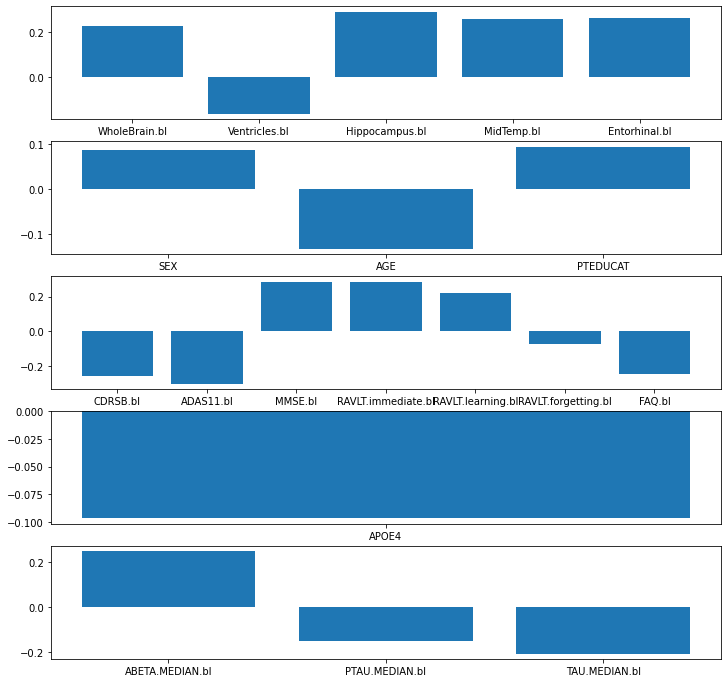

In [240]:
plt.figure(figsize=(12, 12))
plt.subplot(5,1,1)
plt.bar(np.arange(len(decoding_weights[0])), decoding_weights[0], tick_label = volume_cols)
plt.subplot(5,1,2)
plt.bar(np.arange(len(decoding_weights[1])), decoding_weights[1], tick_label = demog_cols)
plt.subplot(5,1,3)
plt.bar(np.arange(len(decoding_weights[2])), decoding_weights[2], tick_label = cognition_cols)
plt.subplot(5,1,4)
plt.bar(np.arange(len(decoding_weights[3])), decoding_weights[3], tick_label = apoe_cols)
plt.subplot(5,1,5)
plt.bar(np.arange(len(decoding_weights[4])), decoding_weights[4], tick_label = fluid_cols)


Once the model is learnt we can use it for prediction. For example we can predict brain volumes from the cognitive data:

In [241]:
# Predicting volumes (channel 0) from cognition (channel 2)
predictions = model_adni.reconstruct(data_adni, reconstruct_from=[2])
decoding_volume_from_cognition = predictions[0].detach().numpy()

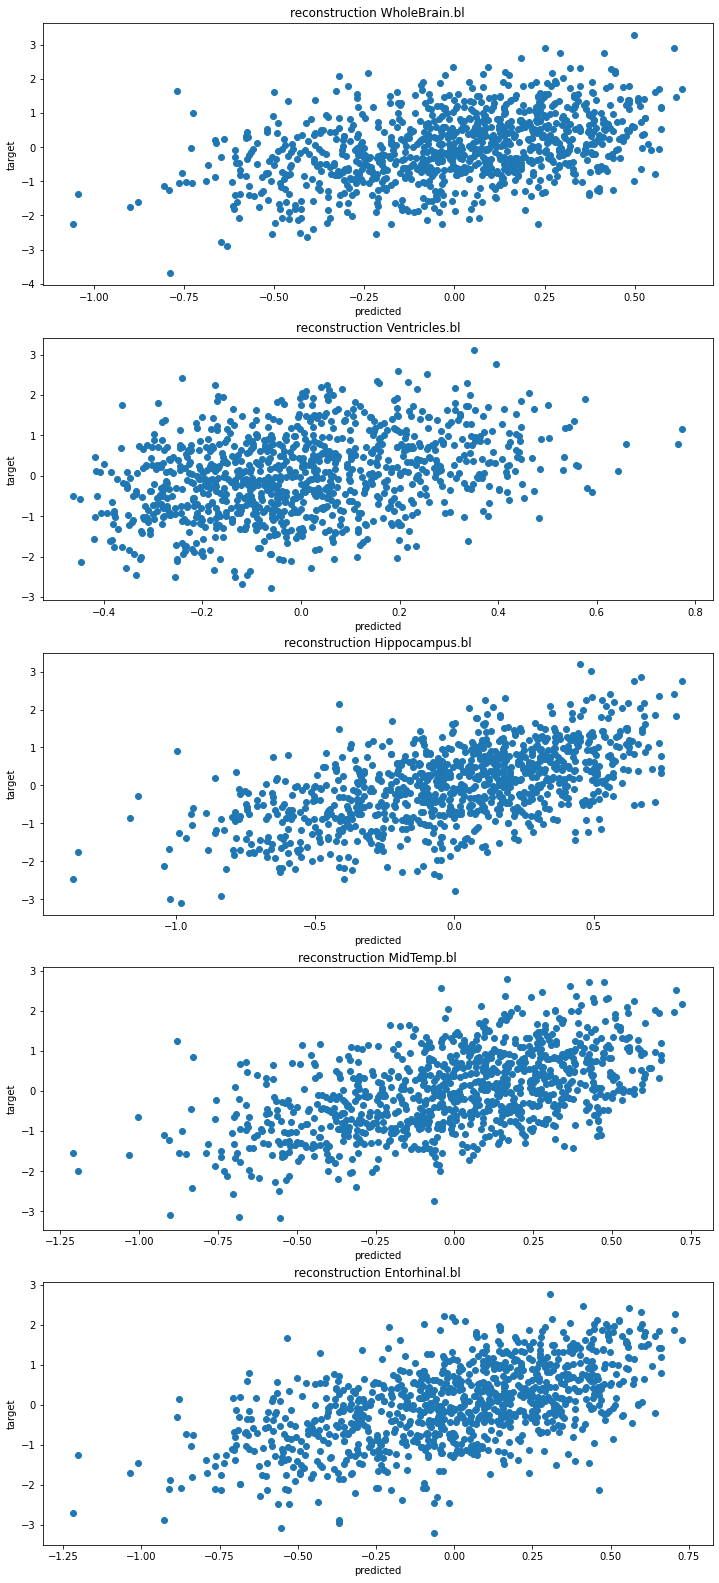

In [242]:
plt.figure(figsize=(12, 28))

# Plotting predictions for each volumetric featurez
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.scatter(decoding_volume_from_cognition[:,i], volumes_value[:,i])
    plt.title('reconstruction ' + volume_cols[i])
    plt.xlabel('predicted')
    plt.ylabel('target')
plt.show()

We are finally going to compare the multichannel model with the standard PLS modeling cognition and brain volumes jointly:

In [252]:
plsca = PLSCanonical(n_components=1, scale = False)
plsca.fit(cognition_value,volumes_value)
print(plsca.x_weights_)
print(plsca.y_weights_)

[[ 0.38442715]
 [ 0.46751116]
 [-0.42755384]
 [-0.41248938]
 [-0.3504303 ]
 [ 0.08267813]
 [ 0.38866726]]
[[-0.38267896]
 [ 0.30522362]
 [-0.51586765]
 [-0.48952454]
 [-0.5046203 ]]


We obtain predictions from the PLS model and compare them with the predictions of mcvae. We observe a strong correlation between predictions. However, it can be noted that as we increase the number of dimensions of CCA, the difference between prediction increases, as CCA tends to overfit. 

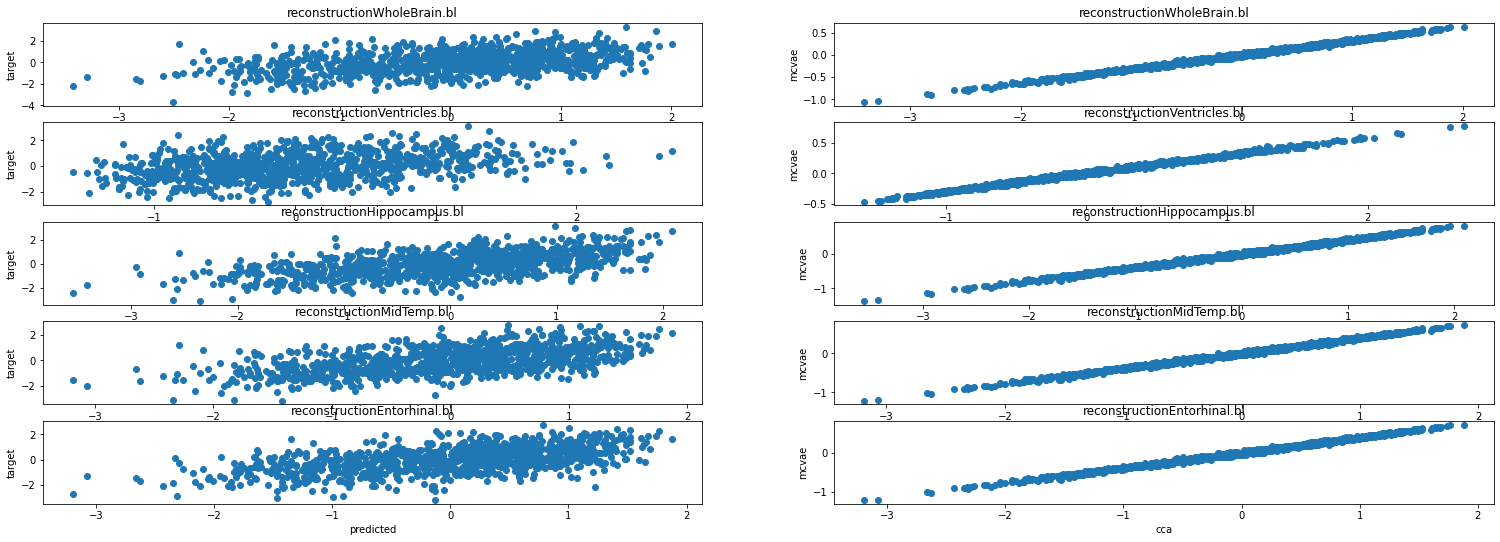

In [253]:
predicted_plsca = plsca.predict(cognition_value)

plt.figure(figsize=(26, 18))

for i in range(5):
    plt.subplot(10,2,2*i+1)
    plt.scatter(predicted_plsca[:,i], volumes_value[:,i])
    plt.title('reconstruction' + volume_cols[i])
    plt.xlabel('predicted')
    plt.ylabel('target')
       
for i in range(5):
    plt.subplot(10,2,2*i+2)
    plt.scatter(predicted_plsca[:,i], decoding_volume_from_cognition[:,i])
    plt.title('reconstruction' + volume_cols[i])
    plt.xlabel('cca')
    plt.ylabel('mcvae')
    
plt.show()

In [254]:
# Comparing average reconstruction errors between models

print('Reconstruction error:')
print('CCA: ' + str(np.sum((predicted_plsca-volumes_value)**2)))
print('mvae: ' + str(np.sum((decoding_volume_from_cognition-volumes_value)**2)))

Reconstruction error:
CCA: 4631.245631476226
mvae: 3916.5451566722413


It is interesting to notice that mcvae leads to a lower reconstruction error than CCA, as the prediction of mcvae benefits from training from other modalities as well.